In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import emcee
import corner
import chainconsumer
import matplotlib as mpl
import matplotlib.patches as mpatches

import t_ratio_parameter_estimation
import axion_mass
import g_star
import eom
import time_temp
import potential
import config
import density_plot
import solver2

In [2]:
df = np.load(config.data_path + "/T_ratio_micro_qcd_parameter.npz")
samples = df["samples"]
take = samples.shape[1] // 4
single_chains = samples[:, take:, :].reshape((-1, t_ratio_parameter_estimation.ndim))
names = t_ratio_parameter_estimation.parameter_names

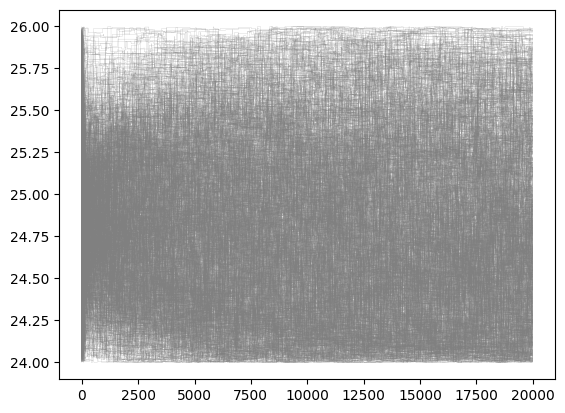

In [31]:
for i in range(samples.shape[0]):
    plt.plot(samples[i, :, 1], color="grey", linewidth=0.1)

In [ ]:
autocorr_fn = emcee.autocorr.function(single_chains)
# autocorr_fn = np.load(config.data_path + "/autocorr_fn_micro_qcd.npz")
for i in range(5):
    plt.plot(autocorr_fn[:, i])
    plt.show()

In [ ]:
for i in range(single_chains.shape[1]):
    plt.plot(single_chains[:, i])
    plt.show()

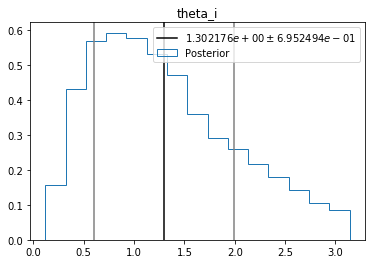

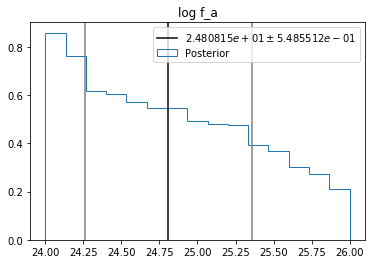

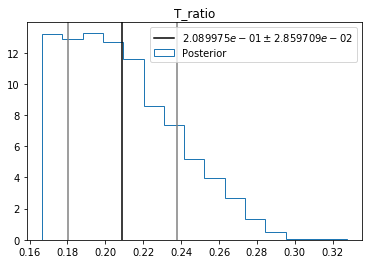

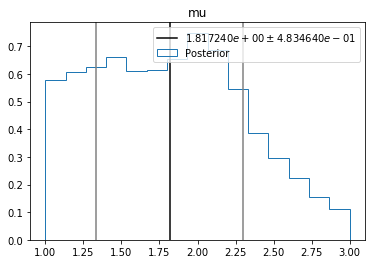

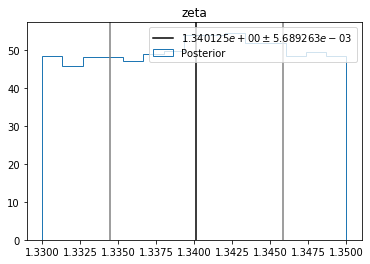

In [3]:
for i, name in enumerate(names):
    plt.title(name)
    std = np.std(single_chains[:, i])
    mean = np.mean(single_chains[:, i])
    plt.hist(single_chains[: , i], bins=15, density=True, histtype="step", label="Posterior")
    plt.axvline(mean - std, color="grey")
    plt.axvline(mean + std, color="grey")
    plt.axvline(mean, color="black", label=r"$%e \pm %e$" % (mean, std))
    plt.legend()
    plt.show()

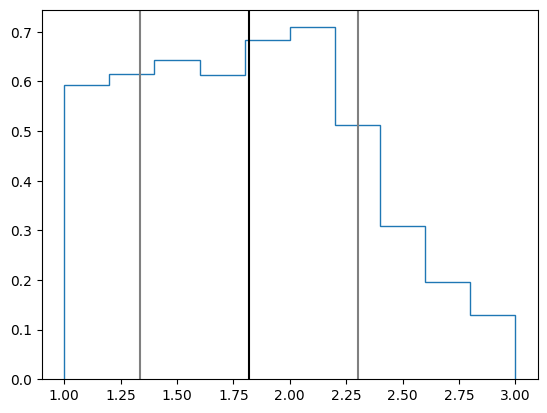

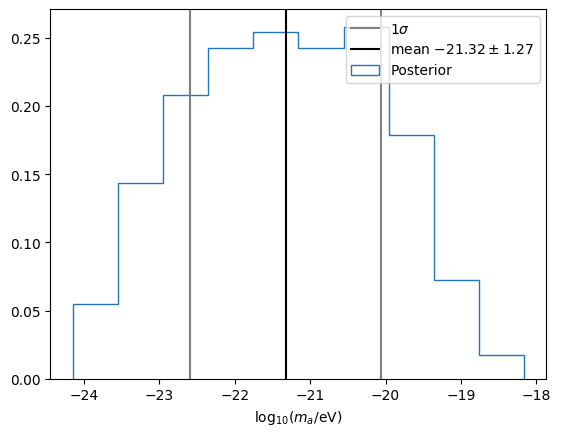

In [37]:
log_mu = single_chains[:, -2]
mu = 10**log_mu
f_a = 10**single_chains[:, 1]
m_a = mu**2 / (np.sqrt(2) * f_a)
log_m_a = np.log10(m_a)

log_mu = np.log10(mu)
mean = np.mean(log_mu)
std = np.std(log_mu)
plt.axvline(mean - std, color="grey")
plt.axvline(mean + std, color="grey")
plt.axvline(mean, color="black", label=r"$%e \pm %e$" % (mean, std))
plt.hist(log_mu, density=True, histtype="step", label="Posterior")
plt.show()

std = np.std(log_m_a)
mean = np.mean(log_m_a)
plt.hist(log_m_a, density=True, histtype="step", label="Posterior")
plt.axvline(mean - std, color="grey")
plt.axvline(mean + std, color="grey", label=r"$1 \sigma$")
plt.axvline(mean, color="black", label=r"mean $%.2f \pm %.2f$" % (mean, std))
plt.xlabel(r"$\log_{10} (m_a / \mathrm{eV})$")
# plt.xlim((-1e-19, 1e-19))
plt.legend()
plt.savefig(config.plot_path + "/micro_qcd_m_a_histogram.pdf")

In [5]:
np.mean(np.log10(f_a)), np.std(np.log10(f_a))

(24.783751531122782, 0.47347046067730469)

In [ ]:
corner.corner(single_chains, labels=t_ratio_parameter_estimation.parameter_names)

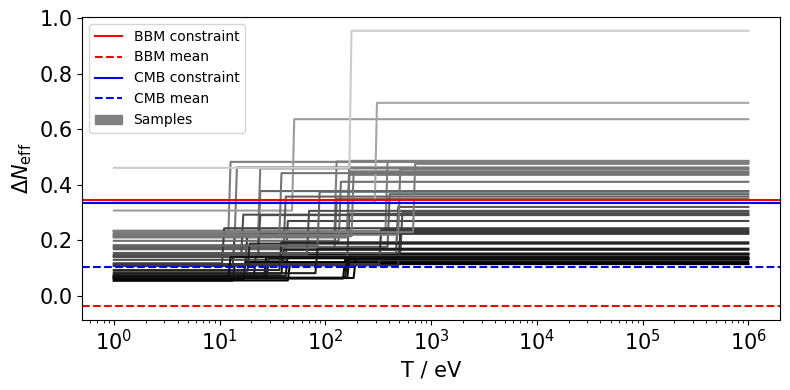

In [39]:
from g_star import compute_Delta_N_eff

T = np.geomspace(1, 1e6, 300)

plt.figure(figsize=(8, 4))
plt.xlabel("T / eV", fontsize=15)
plt.ylabel(r"$\Delta N _ \mathrm{eff}$", fontsize=15)

i = np.random.choice(single_chains.shape[0], 50, replace=False)
t_ratios = single_chains[i, 2]
mus = 10**single_chains[i, -2]
m = min(t_ratios)
span = max(t_ratios) - m
for k, (t_ratio, mu) in enumerate(zip(t_ratios, mus)):
    c = 0.8 * (t_ratio - m) / span
    plt.semilogx(T, list(map(lambda T: compute_Delta_N_eff(t_ratio, T, mu), T)), color=(c,c,c))
# plt.ylim((-0.1, 1))
plt.axhline(t_ratio_parameter_estimation.Delta_N_eff_BBM_mean + t_ratio_parameter_estimation.Delta_N_eff_BBM_err,
           label="BBM constraint", color="red", linestyle="-")
plt.axhline(t_ratio_parameter_estimation.Delta_N_eff_BBM_mean, label="BBM mean", color="red", linestyle="--")
plt.axhline(t_ratio_parameter_estimation.Delta_N_eff_CMB_mean + t_ratio_parameter_estimation.Delta_N_eff_CMB_err,
           label="CMB constraint", color="blue", linestyle="-")
plt.axhline(t_ratio_parameter_estimation.Delta_N_eff_CMB_mean, label="CMB mean", color="blue", linestyle="--")
ax = plt.gca()
ax.tick_params(labelsize=15)
patch = mpatches.Patch(color="grey", label="Samples")
handels, labels = ax.get_legend_handles_labels()
labels.append("Samples")
handels.append(patch)
# plt.legend(labels, handels)
ax.legend(handels, labels)
plt.tight_layout()
plt.savefig(config.plot_path + "/delta_n_eff_micro_qcd.pdf")

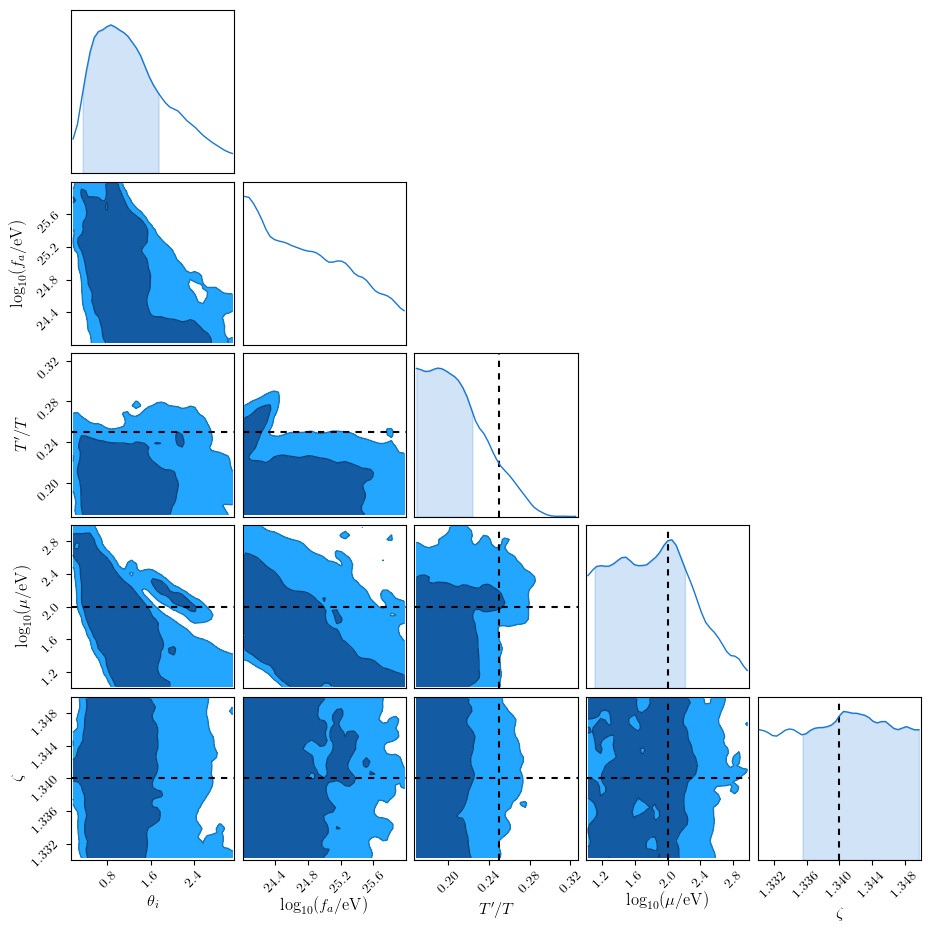

In [36]:
c = chainconsumer.ChainConsumer()
names = [r"$\theta_i$", r"$\log_{10} (f_a / \mathrm{eV})$", "$T' / T$", "$\log_{10}(\mu / \mathrm{eV})$", "$\zeta$"]
c.add_chain(single_chains, parameters=names)
c.configure(smooth=True, plot_point=True, bins=20)
c.plotter.plot(filename=config.plot_path + "/micro_qcd_triangle_plot.pdf",
              truth={"$T' / T$": 1 / 4, "$\log_{10}(\mu / \mathrm{eV})$": 2, "$\zeta$": t_ratio_parameter_estimation.zeta_mean},
              figsize="PAGE")
mpl.rcParams.update(mpl.rcParamsDefault)